# Optuna tutorial for begginers: hyperparameter optimization framework

When I try building a model (XGBoost, LightGBM, CatBoost, Neural Network etc...), I always face an issue of how to tune these hyperparameters?<br>
Some people may be trying to set parameters manually to see if the score improves or not.

**In this tutorial, I will introduce [optuna](https://optuna.org/), *Define-by-Run Hyperparameter Optimization Framework* for automated hyperparameter tuning.**

**<p style="color:red">UPDATE: added <a href="#id6">6. Visualize study history to analayze the hyperparams-performance relationship</a> section, please check!!!</p>**

In [1]:
from IPython.display import HTML

HTML('<iframe width="800" height="400" src="https://www.youtube.com/embed/-UeC4MR3PHM?start=0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Table of Contents:

Below code forked and a bit modified from [ASHRAE: Training LGBM by meter type](https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type) kernel (taken from version 25) until data preprocessing.<br>
Please jump to **[1. Define objective function](#id1)** to start learning optuna usage!

**[ASHRAE - Great Energy Predictor III](#title)** <br>
**[Data Preprocessing](#id0)** <br>
**[1. Define "objective" function](#id1)** <br>
**[2. Use "trial" module to define hyperparameters dynamically!](#id2)** <br>
**[3. Make "study" and let optimize!](#id3)** <br>
**[4. [Advanced] Pruning unpromising trials for more faster search](#id4)** <br>
**[5. Check study history to get best hyperparameters](#id5)** <br>
**[6. Visualize study history to analayze the hyperparams-performance relationship](#id6)** <br>
**[More to go](#id10)** <br>

In [2]:
"""
Some visualization methods used in this tutorial is supported in optuna from v0.18.0 released recently!
However this kaggle kernel pre-installs version 0.16.0
"""
!pip install optuna==0.18.1

     |████████████████████████████████| 122kB 3.4MB/s 
  Created wheel for optuna: filename=optuna-0.18.1-cp36-none-any.whl size=165105 sha256=6ca074e5f988ee3457dcc2b033802f035a5dca792542332c9157622a88ca57b3
  Stored in directory: /tmp/.cache/pip/wheels/40/d2/bd/49b16e74a177e74ea789e677aef515981f021e1979061c4a51
Successfully built optuna
  Found existing installation: optuna 0.16.0
    Uninstalling optuna-0.16.0:
      Successfully uninstalled optuna-0.16.0


<a id="title"></a>
# ASHRAE - Great Energy Predictor III

Our aim in this competition is to predict energy consumption of buildings.

There are 4 types of energy to predict:

 - 0: electricity
 - 1: chilledwater
 - 2: steam
 - 3: hotwater

Electricity and water consumption may have different behavior!
So I tried to separately train & predict the model.

I moved previous [ASHRAE: Simple LGBM submission](https://www.kaggle.com/corochann/ashrae-simple-lgbm-submission) kernel.

In [3]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb


In [4]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
!ls ../input

ashrae-energy-prediction  ashrae-feather-format-for-fast-loading


## Fast data loading

This kernel uses the preprocessed data from my previous kernel, [
ASHRAE: feather format for fast loading](https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading), to accelerate data loading!

In [6]:
%%time
root = Path('../input/ashrae-feather-format-for-fast-loading')

train_df = pd.read_feather(root/'train.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead



CPU times: user 2.14 s, sys: 1.16 s, total: 3.3 s
Wall time: 6.24 s


/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



In [7]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [8]:
np.sum(train_df['meter_reading_log1p'].values < 0)

0

In [9]:
def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = px.line(train_temp_df_meter, x='date', y='meter_reading_log1p')
    fig.show()

In [10]:
plot_date_usage(train_df, meter=0, building_id=0)

## Removing weired data on site_id 0

As you can see above, this data looks weired until May 20. It is reported in [this discussion](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588) by @barnwellguy that **All electricity meter is 0 until May 20 for site_id == 0**. I will remove these data from training data.

It corresponds to `building_id <= 104`.

In [11]:
building_meta_df[building_meta_df.site_id == 0]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
100,0,100,Lodging/residential,24456,1968.0,NaN
101,0,101,Office,18860,1986.0,NaN
102,0,102,Office,15876,1983.0,NaN
103,0,103,Education,21657,2016.0,NaN


In [12]:
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

<a id="id0"></a>
# Data preprocessing

Now, Let's try building GBDT (Gradient Boost Decision Tree) model to predict `meter_reading_log1p`. I will try using LightGBM in this notebook.


[UPDATE]
 - Processing of 'weekend'
 - Take building stats by building_id **and meter type**
 - Align timestamp in weather data, by@nz0722 https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type

In [13]:
debug = False

## Add time feature

Some features introduced in https://www.kaggle.com/ryches/simple-lgbm-solution by @ryches

Features that are likely predictive:

#### Weather

- time of day
- holiday
- weekend
- cloud_coverage + lags
- dew_temperature + lags
- precip_depth + lags
- sea_level_pressure + lags
- wind_direction + lags
- wind_speed + lags

#### Train

- max, mean, min, std of the specific building historically



However we should be careful of putting time feature, since we have only 1 year data in training,
including `date` makes overfiting to training data.

How about `month`? It may be better to check performance by cross validation.
I go not using this data in this kernel for robust modeling.

In [14]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
#     df["day"] = df["timestamp"].dt.day
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["weekend"] = df["dayofweek"] >= 5

#     hour_rad = df["hour"].values / 24. * 2 * np.pi
#     df["hour_sin"] = np.sin(hour_rad)
#     df["hour_cos"] = np.cos(hour_rad)

In [15]:
preprocess(train_df)

In [16]:
# take stats by ONLY building_id. meter type is merged in this script...

# df_group = train_df.groupby('building_id')['meter_reading_log1p']
# building_mean = df_group.mean().astype(np.float16)
# building_median = df_group.median().astype(np.float16)
# building_min = df_group.min().astype(np.float16)
# building_max = df_group.max().astype(np.float16)
# building_std = df_group.std().astype(np.float16)

# train_df['building_mean'] = train_df['building_id'].map(building_mean)
# train_df['building_median'] = train_df['building_id'].map(building_median)
# train_df['building_min'] = train_df['building_id'].map(building_min)
# train_df['building_max'] = train_df['building_id'].map(building_max)
# train_df['building_std'] = train_df['building_id'].map(building_std)

In [17]:
df_group = train_df.groupby(['building_id', 'meter'])['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

In [18]:
building_stats_df = pd.concat([building_mean, building_median, building_min, building_max, building_std], axis=1,
                              keys=['building_mean', 'building_median', 'building_min', 'building_max', 'building_std']).reset_index()
train_df = pd.merge(train_df, building_stats_df, on=['building_id', 'meter'], how='left', copy=False)

In [19]:
train_df.head()

,building_id,meter,timestamp,meter_reading,date,meter_reading_log1p,hour,month,dayofweek,weekend,building_mean,building_median,building_min,building_max,building_std
0,105,0,2016-01-01,23.303600,2016-01-01,3.190624,0,1,4,False,4.316406,4.332031,3.191406,5.164062,0.318115
1,106,0,2016-01-01,0.374600,2016-01-01,0.318163,0,1,4,False,0.751953,0.559082,0.000000,2.890625,0.478516
2,106,3,2016-01-01,0.000000,2016-01-01,0.000000,0,1,4,False,1.023438,0.000000,0.000000,3.712891,1.268555
3,107,0,2016-01-01,175.184006,2016-01-01,5.171529,0,1,4,False,4.570312,5.781250,0.039703,6.382812,2.009766
4,108,0,2016-01-01,91.265297,2016-01-01,4.524668,0,1,4,False,5.457031,5.449219,4.417969,6.113281,0.216187


## Fill Nan value in weather dataframe by interpolation


weather data has a lot of NaNs!!

![](http://)I tried to fill these values by **interpolating** data.

In [20]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0
1,0,2016-01-01 01:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5
2,0,2016-01-01 02:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0
3,0,2016-01-01 03:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0
4,0,2016-01-01 04:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6


In [21]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [22]:
weather_test_df = pd.read_feather(root/'weather_test.feather')
weather = pd.concat([weather_train_df, weather_test_df],ignore_index=True)
del weather_test_df
weather_key = ['site_id', 'timestamp']

In [23]:
# https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type

temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()

# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

del weather
del temp_skeleton
gc.collect()

31009

In [24]:
weather_train_df = timestamp_align(weather_train_df)
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

Seems number of nan has reduced by `interpolate` but some property has never appear in specific `site_id`, and nan remains for these features.

## lags

Adding some lag feature

In [25]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [26]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [27]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 19:00:00,25.000000,6.0,20.0,-1.0,1019.700012,0.0,0.0,5,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 20:00:00,24.400000,4.0,21.1,-1.0,1020.200012,70.0,1.5,5,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 21:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0,5,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 22:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0,5,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2015-12-31 23:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6,5,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [28]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'offset', 'air_temperature_mean_lag3',
       'air_temperature_max_lag3', 'air_temperature_min_lag3',
       'air_temperature_std_lag3', 'cloud_coverage_mean_lag3',
       'cloud_coverage_max_lag3', 'cloud_coverage_min_lag3',
       'cloud_coverage_std_lag3', 'dew_temperature_mean_lag3',
       'dew_temperature_max_lag3', 'dew_temperature_min_lag3',
       'dew_temperature_std_lag3', 'precip_depth_1_hr_mean_lag3',
       'precip_depth_1_hr_max_lag3', 'precip_depth_1_hr_min_lag3',
       'precip_depth_1_hr_std_lag3', 'sea_level_pressure_mean_lag3',
       'sea_level_pressure_max_lag3', 'sea_level_pressure_min_lag3',
       'sea_level_pressure_std_lag3', 'wind_direction_mean_lag3',
       'wind_direction_max_lag3', 'wind_direction_min_lag3',
       'wind_direction_std_lag3', 'wind_speed_mean_lag3',
       'wind_spe

In [29]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


0

In [30]:
reduce_mem_usage(train_df, use_float16=True)
reduce_mem_usage(building_meta_df, use_float16=True)
reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1326.46 MB
Memory usage after optimization is: 795.89 MB
Decreased by 40.0%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.02 MB
Decreased by 24.1%
Memory usage of dataframe is 20.93 MB
Memory usage after optimization is: 18.13 MB
Decreased by 13.4%


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 19:00:00,25.000000,6.0,20.000000,-1.0,1019.5,0.0,0.000000,5,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 20:00:00,24.406250,4.0,21.093750,-1.0,1020.0,70.0,1.500000,5,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 21:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000,5,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 22:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000,5,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2015-12-31 23:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609,5,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 13:00:00,3.000000,1.5,-8.000000,-1.0,1007.5,180.0,5.699219,6,...,1000.0,6.726562,211.000000,310.0,0.0,72.00000,5.046875,11.296875,0.0,2.525391
139769,15,2016-12-31 14:00:00,2.800781,2.0,-8.898438,-1.0,1007.5,180.0,7.699219,6,...,1000.0,6.578125,209.875000,310.0,0.0,71.87500,5.125000,11.296875,0.0,2.519531
139770,15,2016-12-31 15:00:00,2.800781,2.0,-7.199219,-1.0,1007.5,180.0,5.101562,6,...,1000.0,6.421875,212.375000,310.0,0.0,67.43750,5.195312,11.296875,0.0,2.443359
139771,15,2016-12-31 16:00:00,2.199219,2.0,-6.699219,-1.0,1008.0,170.0,4.601562,6,...,1000.0,6.246094,211.375000,310.0,0.0,67.56250,5.226562,11.296875,0.0,2.423828


In [31]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


## Train model

To win in kaggle competition, how to evaluate your model is important.
What kind of cross validation strategy is suitable for this competition? This is time series data, so it is better to consider time-splitting.

However this notebook is for simple tutorial, so I will proceed with KFold splitting without shuffling, so that at least near-term data is not included in validation.

In [32]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
weather_cols = [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3']
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend', 'dayofweek', # 'month'
    'building_median'] + weather_cols

In [33]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

<a id="id1"></a>
# 1. Define "objective" function

To start hyperparameter tuning, we need an objective function to optimize the score.<br>
**`objective` method needs to receive `trial` object as args, and return "score" to be optimized.**<br>
(What is trial module? it is explained in next section) 

```
def objective(trial, ...):
    # calculate score...
    return score
```

Below example, I train LightGBM model (only for electricity meter), get best validation score, and return this validation score as the final score.

**The `objective` function is called many times** by `optuna` framework to try different hyperparameters, to search best hyperparameters.

In [34]:
import optuna
from optuna import Trial

optuna.__version__

'0.18.1'

In [35]:
debug = False

train_df_original = train_df
# Only use 10000 data,,, for fast computation for debugging.
train_df = train_df.sample(10000)

In [36]:
def objective(trial: Trial, fast_check=True, target_meter=0, return_info=False):
    folds = 5
    seed = 666
    shuffle = False
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = create_X_y(train_df, target_meter=target_meter)
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()
    print('target_meter', target_meter, X_train.shape)

    cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
    print('cat_features', cat_features)

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
    #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
        model, y_pred_valid, log = fit_lgbm(trial, train_data, valid_data, cat_features=category_cols,
                                            num_rounds=1000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/l2"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, y_train
    else:
        return valid_score

Here I passed `trial` module to `fit_lgbm` function, which is the core training code and defines hyperparameters.<br>
Let's see inside of `fit_lgbm` module next.

<a id="id2"></a>
# 2. Use "trial" module to define hyperparameters dynamically!

trial module can be used to get hyperparameters.
As shown in below figure, we just need to get hyperparameters from `trial` module where we want to use hyper parameters!

<img src="https://optuna.org/assets/img/define-by-run.png"></img>
from [https://optuna.org/](https://optuna.org/)

This scheme is called "Define-by-Run" which makes user to intuitively write code to get hyperparameters, instead of defining whole search space in advance.

You can call these methods to get hyperparametes (ref: [Defining Parameter Spaces](https://optuna.readthedocs.io/en/latest/tutorial/configurations.html#defining-parameter-spaces)):

    # Categorical parameter
    optimizer = trial.suggest_categorical('optimizer', ['MomentumSGD', 'Adam'])

    # Int parameter
    num_layers = trial.suggest_int('num_layers', 1, 3)

    # Uniform parameter
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 1.0)

    # Loguniform parameter
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Discrete-uniform parameter
    drop_path_rate = trial.suggest_discrete_uniform('drop_path_rate', 0.0, 1.0, 0.1)


In [37]:
# Referred https://github.com/pfnet/optuna/blob/master/examples/lightgbm_simple.py

def fit_lgbm(trial, train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'regression',
#               'max_depth': -1,
        'learning_rate': 0.1,
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/l2': model.best_score['training']['l2'],
           'valid/l2': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

<a id="id3"></a>
# 3. Make "study" and let optimize!

After you define `objective` function and write a code to use hyperparamers by `trial` module, we are ready to go!

Just 2 lines of code do the all troublesome hyperparameter tuning for you. That's all!!

In [38]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.302205	valid_1's l2: 0.482149
[40]	training's l2: 0.157279	valid_1's l2: 0.429399
[60]	training's l2: 0.102717	valid_1's l2: 0.429915
Early stopping, best iteration is:
[45]	training's l2: 0.140231	valid_1's l2: 0.42862
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.14023116335228056}, 'valid_1': {'l2': 0.42861951663422193}})


[I 2019-11-09 09:48:45,547] Finished trial#0 resulted in value: 0.42861951663422193. Current best value is 0.42861951663422193 with parameters: {'num_leaves': 226, 'lambda_l1': 0.09046016729618396, 'lambda_l2': 7.23855585483603e-05, 'bagging_fraction': 0.8140122232113399, 'feature_fraction': 0.566532750940762}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.43267	valid_1's l2: 0.479475
[40]	training's l2: 0.364792	valid_1's l2: 0.441214
[60]	training's l2: 0.35012	valid_1's l2: 0.442439
Early stopping, best iteration is:
[48]	training's l2: 0.355694	valid_1's l2: 0.437259
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3556941099156304}, 'valid_1': {'l2': 0.43725940190731394}})


[I 2019-11-09 09:48:46,813] Finished trial#1 resulted in value: 0.43725940190731394. Current best value is 0.42861951663422193 with parameters: {'num_leaves': 226, 'lambda_l1': 0.09046016729618396, 'lambda_l2': 7.23855585483603e-05, 'bagging_fraction': 0.8140122232113399, 'feature_fraction': 0.566532750940762}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.372903	valid_1's l2: 0.452575
[40]	training's l2: 0.274832	valid_1's l2: 0.410896
[60]	training's l2: 0.233068	valid_1's l2: 0.402297
[80]	training's l2: 0.205166	valid_1's l2: 0.404155
Early stopping, best iteration is:
[66]	training's l2: 0.224659	valid_1's l2: 0.401085
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.22465862831691363}, 'valid_1': {'l2': 0.4010850610496971}})


[I 2019-11-09 09:48:48,029] Finished trial#2 resulted in value: 0.4010850610496971. Current best value is 0.4010850610496971 with parameters: {'num_leaves': 19, 'lambda_l1': 0.001243851300582949, 'lambda_l2': 0.06413117312652389, 'bagging_fraction': 0.7756285537261676, 'feature_fraction': 0.8761909204139479}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.511356	valid_1's l2: 0.538333
[40]	training's l2: 0.403798	valid_1's l2: 0.445153
[60]	training's l2: 0.378285	valid_1's l2: 0.432512
Early stopping, best iteration is:
[50]	training's l2: 0.382247	valid_1's l2: 0.428229
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3822473440288139}, 'valid_1': {'l2': 0.42822912212809255}})


[I 2019-11-09 09:48:49,109] Finished trial#3 resulted in value: 0.42822912212809255. Current best value is 0.4010850610496971 with parameters: {'num_leaves': 19, 'lambda_l1': 0.001243851300582949, 'lambda_l2': 0.06413117312652389, 'bagging_fraction': 0.7756285537261676, 'feature_fraction': 0.8761909204139479}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.453882	valid_1's l2: 0.487076
[40]	training's l2: 0.37598	valid_1's l2: 0.421918
[60]	training's l2: 0.360839	valid_1's l2: 0.410934
Early stopping, best iteration is:
[59]	training's l2: 0.361216	valid_1's l2: 0.410713
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3612155949139755}, 'valid_1': {'l2': 0.41071331547676054}})


[I 2019-11-09 09:48:49,968] Finished trial#4 resulted in value: 0.41071331547676054. Current best value is 0.4010850610496971 with parameters: {'num_leaves': 19, 'lambda_l1': 0.001243851300582949, 'lambda_l2': 0.06413117312652389, 'bagging_fraction': 0.7756285537261676, 'feature_fraction': 0.8761909204139479}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.32542	valid_1's l2: 0.45528
[40]	training's l2: 0.193661	valid_1's l2: 0.410921
[60]	training's l2: 0.132994	valid_1's l2: 0.410771
Early stopping, best iteration is:
[50]	training's l2: 0.159655	valid_1's l2: 0.407704
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.159654693771976}, 'valid_1': {'l2': 0.4077039669894617}})


[I 2019-11-09 09:48:51,707] Finished trial#5 resulted in value: 0.4077039669894617. Current best value is 0.4010850610496971 with parameters: {'num_leaves': 19, 'lambda_l1': 0.001243851300582949, 'lambda_l2': 0.06413117312652389, 'bagging_fraction': 0.7756285537261676, 'feature_fraction': 0.8761909204139479}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.436745	valid_1's l2: 0.49842
[40]	training's l2: 0.325518	valid_1's l2: 0.434114
[60]	training's l2: 0.29152	valid_1's l2: 0.426565
Early stopping, best iteration is:
[53]	training's l2: 0.300079	valid_1's l2: 0.423875
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3000785454816165}, 'valid_1': {'l2': 0.42387474355636684}})


[I 2019-11-09 09:48:52,988] Finished trial#6 resulted in value: 0.42387474355636684. Current best value is 0.4010850610496971 with parameters: {'num_leaves': 19, 'lambda_l1': 0.001243851300582949, 'lambda_l2': 0.06413117312652389, 'bagging_fraction': 0.7756285537261676, 'feature_fraction': 0.8761909204139479}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.409225	valid_1's l2: 0.467417
[40]	training's l2: 0.336044	valid_1's l2: 0.434459
Early stopping, best iteration is:
[37]	training's l2: 0.339435	valid_1's l2: 0.432785
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3394351078066477}, 'valid_1': {'l2': 0.43278504979046495}})


[I 2019-11-09 09:48:54,299] Finished trial#7 resulted in value: 0.43278504979046495. Current best value is 0.4010850610496971 with parameters: {'num_leaves': 19, 'lambda_l1': 0.001243851300582949, 'lambda_l2': 0.06413117312652389, 'bagging_fraction': 0.7756285537261676, 'feature_fraction': 0.8761909204139479}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.345071	valid_1's l2: 0.447466
[40]	training's l2: 0.241783	valid_1's l2: 0.4144
[60]	training's l2: 0.194245	valid_1's l2: 0.407689
[80]	training's l2: 0.160857	valid_1's l2: 0.408125
Early stopping, best iteration is:
[70]	training's l2: 0.17629	valid_1's l2: 0.406203
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.1762900011705107}, 'valid_1': {'l2': 0.4062033904891735}})


[I 2019-11-09 09:48:55,966] Finished trial#8 resulted in value: 0.4062033904891735. Current best value is 0.4010850610496971 with parameters: {'num_leaves': 19, 'lambda_l1': 0.001243851300582949, 'lambda_l2': 0.06413117312652389, 'bagging_fraction': 0.7756285537261676, 'feature_fraction': 0.8761909204139479}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.408182	valid_1's l2: 0.526916
[40]	training's l2: 0.245882	valid_1's l2: 0.434539
[60]	training's l2: 0.188973	valid_1's l2: 0.420073
[80]	training's l2: 0.152099	valid_1's l2: 0.420751
Early stopping, best iteration is:
[70]	training's l2: 0.169307	valid_1's l2: 0.419517
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.16930680424123454}, 'valid_1': {'l2': 0.41951744628943105}})


[I 2019-11-09 09:48:57,811] Finished trial#9 resulted in value: 0.41951744628943105. Current best value is 0.4010850610496971 with parameters: {'num_leaves': 19, 'lambda_l1': 0.001243851300582949, 'lambda_l2': 0.06413117312652389, 'bagging_fraction': 0.7756285537261676, 'feature_fraction': 0.8761909204139479}.


## Summary of trial & study

 - **`trial` manages each execution of model training, evaluation, getting a score by specifying one trial of hyperparameter**
 - **`study` manages all history of `trial`. So that we can know best hyperparamers, and suggest next hyperparameters to search etc**


## Sampler

`optuna` provides many types of `Sampler` class to suggest next hyperparameters. (Ref: [sampler](https://optuna.readthedocs.io/en/stable/tutorial/sampler.html))

Default behavior is to use TPE algorithm, which is same with famous `hyperopt` library. This is kind of a bayesian optimization based sampling.


## FAQ: How to define objective functions that have own arguments?

`study.optimize` method receives `objective` method with `trial` args, how to pass other 2nd, 3rd argument?<br>
We can use class or lambda expression.<br>
For example, `study.optimize(lambda trial: objective(trial, arg0=1, arg1=2), n_trials=100)`<br>

Refer [How to define objective functions that have own arguments?](https://optuna.readthedocs.io/en/latest/faq.html#how-to-define-objective-functions-that-have-own-arguments) for details.

<a id="id4"></a>
# 4. [Advanced] Pruning unpromising trials for more faster search

Another important functionality is **"pruning"**. When human try hyperparameter tuning, we usually stop training earlier when the learning curve was much worse than the best known result.

`optuna` provides pruning feature, and also provides integration modules for famous ML framework so that user can easily try pruning during hyperparameter optimization.<br>
Supported modules are following

 - XGBoost: `optuna.integration.XGBoostPruningCallback`
 - LightGBM: `optuna.integration.LightGBMPruningCallback`
 - Chainer: `optuna.integration.ChainerPruningExtension`
 - Keras: `optuna.integration.KerasPruningCallback`
 - TensorFlow `optuna.integration.TensorFlowPruningHook`
 - tf.keras `optuna.integration.TFKerasPruningCallback`
 - MXNet `optuna.integration.MXNetPruningCallback`

See [pruning](https://optuna.readthedocs.io/en/stable/tutorial/pruning.html) section for details.

<img src="https://optuna.org/assets/img/pruning-example-with-caption.png"></img>

I just added `LightGBMPruningCallback` for LightGBM training.<br>
The difference is only 2 line. Define `pruning_callback` and set it in `lgb.train` method.

The example below will check validation score each iteration for pruning.

In [39]:
# Referred https://github.com/pfnet/optuna/blob/master/examples/pruning/lightgbm_integration.py

def fit_lgbm_with_pruning(trial, train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'regression',
#               'max_depth': -1,
        'learning_rate': 0.1,
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'l2', valid_name='valid_1')    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                      callbacks=[pruning_callback])

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/l2': model.best_score['training']['l2'],
           'valid/l2': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [40]:
def objective_with_prune(trial: Trial, fast_check=True, target_meter=0):
    """This method is completely same with previous `objective` method except calling `fit_lgbm_with_pruning`"""
    folds = 5
    seed = 666
    shuffle = False
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = create_X_y(train_df, target_meter=target_meter)
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()
    print('target_meter', target_meter, X_train.shape)

    cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
    print('cat_features', cat_features)

    models0 = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit_lgbm_with_pruning(trial, train_data, valid_data, cat_features=category_cols,
                                                         num_rounds=1000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models0.append(model)
        gc.collect()
        valid_score += log["valid/l2"]
        if fast_check:
            break
    valid_score /= len(models0)
    return valid_score

Then you can again create `study` object with **setting `pruner` object**, and let optimize!

`pruner` class defines strategy how to prune in each intermediate step.<br>
`MedianPruner` used in this example just check reported value each iteration, and if its score is higher than the median value of whole study history in this iteration, prunes.

In [41]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective_with_prune, n_trials=50)

target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.451598	valid_1's l2: 0.497152
[40]	training's l2: 0.348145	valid_1's l2: 0.427774
[60]	training's l2: 0.320581	valid_1's l2: 0.424482
[80]	training's l2: 0.298158	valid_1's l2: 0.433377
Early stopping, best iteration is:
[62]	training's l2: 0.318774	valid_1's l2: 0.422976
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3187738747336559}, 'valid_1': {'l2': 0.4229764713311718}})


[I 2019-11-09 09:48:59,388] Finished trial#0 resulted in value: 0.4229764713311718. Current best value is 0.4229764713311718 with parameters: {'num_leaves': 40, 'lambda_l1': 3.740303416286662e-07, 'lambda_l2': 0.006498806158158513, 'bagging_fraction': 0.1631280698154729, 'feature_fraction': 0.5354360287276999}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.394355	valid_1's l2: 0.45462
[40]	training's l2: 0.309339	valid_1's l2: 0.411264
[60]	training's l2: 0.272679	valid_1's l2: 0.40005
[80]	training's l2: 0.24734	valid_1's l2: 0.397812
Early stopping, best iteration is:
[70]	training's l2: 0.25897	valid_1's l2: 0.397111
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.2589704104070188}, 'valid_1': {'l2': 0.39711087086406155}})


[I 2019-11-09 09:49:00,577] Finished trial#1 resulted in value: 0.39711087086406155. Current best value is 0.39711087086406155 with parameters: {'num_leaves': 13, 'lambda_l1': 1.36953503646408e-07, 'lambda_l2': 1.5465589025080418e-07, 'bagging_fraction': 0.6721616082603946, 'feature_fraction': 0.9717396775319959}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.365803	valid_1's l2: 0.453659
[40]	training's l2: 0.267176	valid_1's l2: 0.411482
[60]	training's l2: 0.227192	valid_1's l2: 0.408493
Early stopping, best iteration is:
[53]	training's l2: 0.237851	valid_1's l2: 0.405595
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.23785105421516958}, 'valid_1': {'l2': 0.4055950437356685}})


[I 2019-11-09 09:49:02,326] Finished trial#2 resulted in value: 0.4055950437356685. Current best value is 0.39711087086406155 with parameters: {'num_leaves': 13, 'lambda_l1': 1.36953503646408e-07, 'lambda_l2': 1.5465589025080418e-07, 'bagging_fraction': 0.6721616082603946, 'feature_fraction': 0.9717396775319959}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.454701	valid_1's l2: 0.489488
[40]	training's l2: 0.372499	valid_1's l2: 0.430149
[60]	training's l2: 0.34797	valid_1's l2: 0.422969
[80]	training's l2: 0.332845	valid_1's l2: 0.418545
[100]	training's l2: 0.322533	valid_1's l2: 0.417349
[120]	training's l2: 0.313455	valid_1's l2: 0.414961
[140]	training's l2: 0.307598	valid_1's l2: 0.413592
[160]	training's l2: 0.300216	valid_1's l2: 0.411644
[180]	training's l2: 0.293566	valid_1's l2: 0.41297
Early stopping, best iteration is:
[172]	training's l2: 0.295889	valid_1's l2: 0.41064
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.2958886044028397}, 'valid_1': {'l2': 0.41064026299015116}})


[I 2019-11-09 09:49:04,037] Finished trial#3 resulted in value: 0.41064026299015116. Current best value is 0.39711087086406155 with parameters: {'num_leaves': 13, 'lambda_l1': 1.36953503646408e-07, 'lambda_l2': 1.5465589025080418e-07, 'bagging_fraction': 0.6721616082603946, 'feature_fraction': 0.9717396775319959}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.538388	valid_1's l2: 0.558457
[40]	training's l2: 0.408725	valid_1's l2: 0.442953
[60]	training's l2: 0.376813	valid_1's l2: 0.421525
[80]	training's l2: 0.359897	valid_1's l2: 0.419787
Early stopping, best iteration is:
[70]	training's l2: 0.36888	valid_1's l2: 0.41689
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.36888032877677185}, 'valid_1': {'l2': 0.41689025872906593}})


[I 2019-11-09 09:49:05,201] Finished trial#4 resulted in value: 0.41689025872906593. Current best value is 0.39711087086406155 with parameters: {'num_leaves': 13, 'lambda_l1': 1.36953503646408e-07, 'lambda_l2': 1.5465589025080418e-07, 'bagging_fraction': 0.6721616082603946, 'feature_fraction': 0.9717396775319959}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.313334	valid_1's l2: 0.457691
[40]	training's l2: 0.196438	valid_1's l2: 0.419368
[60]	training's l2: 0.142789	valid_1's l2: 0.413865
[80]	training's l2: 0.107775	valid_1's l2: 0.412754
Early stopping, best iteration is:
[70]	training's l2: 0.124304	valid_1's l2: 0.411392
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.12430351139757616}, 'valid_1': {'l2': 0.41139234244212813}})


[I 2019-11-09 09:49:07,856] Finished trial#5 resulted in value: 0.41139234244212813. Current best value is 0.39711087086406155 with parameters: {'num_leaves': 13, 'lambda_l1': 1.36953503646408e-07, 'lambda_l2': 1.5465589025080418e-07, 'bagging_fraction': 0.6721616082603946, 'feature_fraction': 0.9717396775319959}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.3987	valid_1's l2: 0.46259


[I 2019-11-09 09:49:08,555] Setting status of trial#6 as TrialState.PRUNED. Trial was pruned at iteration 29.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:09,306] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.340202	valid_1's l2: 0.454175
[40]	training's l2: 0.23153	valid_1's l2: 0.409103
[60]	training's l2: 0.183664	valid_1's l2: 0.406657
Early stopping, best iteration is:
[57]	training's l2: 0.190075	valid_1's l2: 0.40551
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.19007502576538213}, 'valid_1': {'l2': 0.40550971883344616}})


[I 2019-11-09 09:49:11,291] Finished trial#8 resulted in value: 0.40550971883344616. Current best value is 0.39711087086406155 with parameters: {'num_leaves': 13, 'lambda_l1': 1.36953503646408e-07, 'lambda_l2': 1.5465589025080418e-07, 'bagging_fraction': 0.6721616082603946, 'feature_fraction': 0.9717396775319959}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:11,806] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.291321	valid_1's l2: 0.453916


[I 2019-11-09 09:49:12,852] Setting status of trial#10 as TrialState.PRUNED. Trial was pruned at iteration 21.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:13,644] Setting status of trial#11 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:14,355] Setting status of trial#12 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:15,133] Setting status of trial#13 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:15,977] Setting status of trial#14 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.340299	valid_1's l2: 0.453609


[I 2019-11-09 09:49:17,154] Setting status of trial#15 as TrialState.PRUNED. Trial was pruned at iteration 37.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.332837	valid_1's l2: 0.451777


[I 2019-11-09 09:49:18,450] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at iteration 29.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:19,276] Setting status of trial#17 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:20,203] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:21,229] Setting status of trial#19 as TrialState.PRUNED. Trial was pruned at iteration 15.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.324118	valid_1's l2: 0.443379


[I 2019-11-09 09:49:22,570] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at iteration 37.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:23,518] Setting status of trial#21 as TrialState.PRUNED. Trial was pruned at iteration 15.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:24,349] Setting status of trial#22 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:25,094] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:26,198] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at iteration 16.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:27,068] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at iteration 15.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:27,982] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:28,721] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:29,582] Setting status of trial#28 as TrialState.PRUNED. Trial was pruned at iteration 17.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.319666	valid_1's l2: 0.44881
[40]	training's l2: 0.211872	valid_1's l2: 0.412859
[60]	training's l2: 0.161327	valid_1's l2: 0.410193
[80]	training's l2: 0.127817	valid_1's l2: 0.408467
Early stopping, best iteration is:
[73]	training's l2: 0.137729	valid_1's l2: 0.407277
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.1377294602205185}, 'valid_1': {'l2': 0.4072771809442091}})


[I 2019-11-09 09:49:32,435] Finished trial#29 resulted in value: 0.4072771809442091. Current best value is 0.39711087086406155 with parameters: {'num_leaves': 13, 'lambda_l1': 1.36953503646408e-07, 'lambda_l2': 1.5465589025080418e-07, 'bagging_fraction': 0.6721616082603946, 'feature_fraction': 0.9717396775319959}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:33,312] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at iteration 14.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.358364	valid_1's l2: 0.44618
[40]	training's l2: 0.264201	valid_1's l2: 0.406818
[60]	training's l2: 0.219959	valid_1's l2: 0.401431
[80]	training's l2: 0.18874	valid_1's l2: 0.398162
[100]	training's l2: 0.16537	valid_1's l2: 0.400556
Early stopping, best iteration is:
[92]	training's l2: 0.173048	valid_1's l2: 0.396386
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.17304755669904143}, 'valid_1': {'l2': 0.3963856529988956}})


[I 2019-11-09 09:49:36,371] Finished trial#31 resulted in value: 0.3963856529988956. Current best value is 0.3963856529988956 with parameters: {'num_leaves': 22, 'lambda_l1': 0.5973544239449707, 'lambda_l2': 0.00481032733282212, 'bagging_fraction': 0.816949890064531, 'feature_fraction': 0.9512723611492626}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.367536	valid_1's l2: 0.450518
[40]	training's l2: 0.273419	valid_1's l2: 0.401712
[60]	training's l2: 0.233321	valid_1's l2: 0.393072
[80]	training's l2: 0.20603	valid_1's l2: 0.39468
Early stopping, best iteration is:
[67]	training's l2: 0.22316	valid_1's l2: 0.39177
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.22315980495240312}, 'valid_1': {'l2': 0.391769546475642}})


[I 2019-11-09 09:49:38,753] Finished trial#32 resulted in value: 0.391769546475642. Current best value is 0.391769546475642 with parameters: {'num_leaves': 17, 'lambda_l1': 0.03280599745495849, 'lambda_l2': 0.1609433676848143, 'bagging_fraction': 0.907447663961603, 'feature_fraction': 0.9526656120616738}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.366817	valid_1's l2: 0.446496
[40]	training's l2: 0.273301	valid_1's l2: 0.404131
[60]	training's l2: 0.232287	valid_1's l2: 0.394737
[80]	training's l2: 0.204933	valid_1's l2: 0.394183
Early stopping, best iteration is:
[73]	training's l2: 0.213357	valid_1's l2: 0.393329
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.21335704201184316}, 'valid_1': {'l2': 0.3933288991693753}})


[I 2019-11-09 09:49:41,183] Finished trial#33 resulted in value: 0.3933288991693753. Current best value is 0.391769546475642 with parameters: {'num_leaves': 17, 'lambda_l1': 0.03280599745495849, 'lambda_l2': 0.1609433676848143, 'bagging_fraction': 0.907447663961603, 'feature_fraction': 0.9526656120616738}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.377497	valid_1's l2: 0.451679
[40]	training's l2: 0.284876	valid_1's l2: 0.404028
[60]	training's l2: 0.244101	valid_1's l2: 0.396663
[80]	training's l2: 0.21617	valid_1's l2: 0.394835
Early stopping, best iteration is:
[74]	training's l2: 0.22316	valid_1's l2: 0.394465
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.22316048038901506}, 'valid_1': {'l2': 0.39446467968516447}})


[I 2019-11-09 09:49:43,486] Finished trial#34 resulted in value: 0.39446467968516447. Current best value is 0.391769546475642 with parameters: {'num_leaves': 17, 'lambda_l1': 0.03280599745495849, 'lambda_l2': 0.1609433676848143, 'bagging_fraction': 0.907447663961603, 'feature_fraction': 0.9526656120616738}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:44,173] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at iteration 7.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:44,924] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:45,773] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.301855	valid_1's l2: 0.448731


[I 2019-11-09 09:49:47,060] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at iteration 26.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.328808	valid_1's l2: 0.446051


[I 2019-11-09 09:49:48,620] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at iteration 34.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:49,397] Setting status of trial#40 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:50,204] Setting status of trial#41 as TrialState.PRUNED. Trial was pruned at iteration 7.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.3635	valid_1's l2: 0.447107
[40]	training's l2: 0.270991	valid_1's l2: 0.406081
[60]	training's l2: 0.22781	valid_1's l2: 0.398592
[80]	training's l2: 0.199096	valid_1's l2: 0.399098
Early stopping, best iteration is:
[69]	training's l2: 0.214383	valid_1's l2: 0.397267
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.21438325118910434}, 'valid_1': {'l2': 0.3972666344878287}})


[I 2019-11-09 09:49:53,111] Finished trial#42 resulted in value: 0.3972666344878287. Current best value is 0.391769546475642 with parameters: {'num_leaves': 17, 'lambda_l1': 0.03280599745495849, 'lambda_l2': 0.1609433676848143, 'bagging_fraction': 0.907447663961603, 'feature_fraction': 0.9526656120616738}.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:53,712] Setting status of trial#43 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.33252	valid_1's l2: 0.450031


[I 2019-11-09 09:49:55,050] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at iteration 25.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:56,066] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at iteration 7.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:56,991] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:58,076] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at iteration 10.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:59,067] Setting status of trial#48 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5953, 35)
cat_features [32, 33, 34]
train 4762 valid 1191
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:49:59,996] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at iteration 7.


Now you can check this kind of message:

> [I 2019-10-28 13:03:33,408] Setting status of trial#15 as TrialState.PRUNED. Trial was pruned at iteration 6.

Some unpromised trial is pruned before totally taining the model, so that we can check more trial!

<a id="id5"></a>
# 5. Check study history to get best hyperparameters

Now we've done hyperparameter optimization. So we want to know the best hyperparameters.<br>
Whole `trial` history is managed in `study` object, we can get best trial by **`study.best_trial`**

In [42]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

# It has alias, below is also same.
# print('Best trial: score {}, params {}'.format(study.best_value, study.best_params))

Best trial: score 0.391769546475642, params {'num_leaves': 17, 'lambda_l1': 0.03280599745495849, 'lambda_l2': 0.1609433676848143, 'bagging_fraction': 0.907447663961603, 'feature_fraction': 0.9526656120616738}


Another tips: If you want to see all the history of trials, you can get `pandas.DataFrame` format by calling `study.trials_dataframe()`.

In [43]:
trials_df = study.trials_dataframe()
trials_df

number                state     value             datetime_start  \
                                                                      
0       0  TrialState.COMPLETE  0.422976 2019-11-09 09:48:58.126685   
1       1  TrialState.COMPLETE  0.397111 2019-11-09 09:48:59.391329   
2       2  TrialState.COMPLETE  0.405595 2019-11-09 09:49:00.580185   
3       3  TrialState.COMPLETE  0.410640 2019-11-09 09:49:02.329879   
4       4  TrialState.COMPLETE  0.416890 2019-11-09 09:49:04.040552   
5       5  TrialState.COMPLETE  0.411392 2019-11-09 09:49:05.204676   
6       6    TrialState.PRUNED  0.435951 2019-11-09 09:49:07.859717   
7       7    TrialState.PRUNED  1.029388 2019-11-09 09:49:08.839572   
8       8  TrialState.COMPLETE  0.405510 2019-11-09 09:49:09.505088   
9       9    TrialState.PRUNED  0.913327 2019-11-09 09:49:11.294172   
10     10    TrialState.PRUNED  0.444720 2019-11-09 09:49:11.997335   
11     11    TrialState.PRUNED  0.936488 2019-11-09 09:49:13.047567   
12     12    TrialState.PRUNED  0.934973 2019-11-09 09:49:13.867398   
13     13    TrialState.PRUNED  0.912262 2019-11-09 09:49:14.547493   
14     14    TrialState.PRUNED  0.946480 2019-11-09 09:49:15.417058   
15     15    TrialState.PRUNED  0.419160 2019-11-09 09:49:16.200418   
16     16    TrialState.PRUNED  0.427017 2019-11-09 09:49:17.428773   
17     17    TrialState.PRUNED  0.913130 2019-11-09 09:49:18.672680   
18     18    TrialState.PRUNED  1.037446 2019-11-09 09:49:19.554999   
19     19    TrialState.PRUNED  0.510250 2019-11-09 09:49:20.476974   
20     20    TrialState.PRUNED  0.420166 2019-11-09 09:49:21.429209   
21     21    TrialState.PRUNED  0.509504 2019-11-09 09:49:22.762268   
22     22    TrialState.PRUNED  0.924597 2019-11-09 09:49:23.801650   
23     23    TrialState.PRUNED  0.940969 2019-11-09 09:49:24.542738   
24     24    TrialState.PRUNED  0.490295 2019-11-09 09:49:25.370041   
25     25    TrialState.PRUNED  0.512021 2019-11-09 09:49:26.426448   
26     26    TrialState.PRUNED  0.937042 2019-11-09 09:49:27.340763   
27     27    TrialState.PRUNED  0.932413 2019-11-09 09:49:28.205258   
28     28    TrialState.PRUNED  0.476984 2019-11-09 09:49:28.907750   
29     29  TrialState.COMPLETE  0.407277 2019-11-09 09:49:29.774936   
30     30    TrialState.PRUNED  0.533867 2019-11-09 09:49:32.438163   
31     31  TrialState.COMPLETE  0.396386 2019-11-09 09:49:33.592718   
32     32  TrialState.COMPLETE  0.391770 2019-11-09 09:49:36.374656   
33     33  TrialState.COMPLETE  0.393329 2019-11-09 09:49:38.756926   
34     34  TrialState.COMPLETE  0.394465 2019-11-09 09:49:41.186961   
35     35    TrialState.PRUNED  0.800603 2019-11-09 09:49:43.489492   
36     36    TrialState.PRUNED  0.897578 2019-11-09 09:49:44.382143   
37     37    TrialState.PRUNED  1.318954 2019-11-09 09:49:45.200833   
38     38    TrialState.PRUNED  0.423271 2019-11-09 09:49:45.961422   
39     39    TrialState.PRUNED  0.415572 2019-11-09 09:49:47.333932   
40     40    TrialState.PRUNED  0.925962 2019-11-09 09:49:48.840183   
41     41    TrialState.PRUNED  0.801059 2019-11-09 09:49:49.589478   
42     42  TrialState.COMPLETE  0.397267 2019-11-09 09:49:50.393049   
43     43    TrialState.PRUNED  1.086992 2019-11-09 09:49:53.114532   
44     44    TrialState.PRUNED  0.425153 2019-11-09 09:49:53.929660   
45     45    TrialState.PRUNED  0.800462 2019-11-09 09:49:55.335056   
46     46    TrialState.PRUNED  0.905333 2019-11-09 09:49:56.347780   
47     47    TrialState.PRUNED  0.646363 2019-11-09 09:49:57.262748   
48     48    TrialState.PRUNED  0.902063 2019-11-09 09:49:58.358638   
49     49    TrialState.PRUNED  0.800601 2019-11-09 09:49:59.294650   

            datetime_complete           params                                 \
                              bagging_fraction feature_fraction     lambda_l1   
0  2019-11-09 09:48:59.387033         0.163128         0.535436  3.740303e-07   
1  2019-11-09 09:49:00.576226         0.672162         0.971740  1.

<a id="id6"></a>
# 6. Visualize study history to analayze the hyperparams-performance relationship

Since we have history of trials, we can analyze how each hyperparams affects to the performance.<br>
All the visualization below can be done in just one line!!!

(Acknowledgement: thank you @shotaro for let me know this feature)

## Optimization history

It is a best score's history, blue dot is the score of this trial and orange line show the best score.<br>
Note that blue dot is not in the all trial, because we turned on pruning thus many of the trials are stopped before getting final objective value.

In [44]:
optuna.visualization.plot_optimization_history(study)

## Visualize pruning history

You can visualize how the pruning is executed!<br>
Each color shows the loss curve of each trial.

In [45]:
optuna.visualization.plot_intermediate_values(study)

## Visualize plot slice

We can see how the optuna's sampler searches hyperparameter space.<br>
The white dots are searched in the early stage, while blue dots are searched in the later stage.

We can see following behavior (This is for the debugging small train_df training, actual dataset behavior maybe different!)

 - `feature_fraction`: Low value (0.4~0.8) got very but score at the begging of trial, and thus high value (0.9~1.0) are extensively searched in the later stage.
 - `num_leaves`      : Intermediate value around 32~64 are extensively searched in the later stage, which may be "reasonable".

In [46]:
optuna.visualization.plot_slice(study)

## Visualize plot contour

We can see 2 parametes pair plot with objective value as contour.

In [47]:
optuna.visualization.plot_contour(study)

## Visualize parallel_coordinate

When I check the best valued line, which is most blue color line starts from left-bottom, we can see following behavior:

 - higher high feature_fraction seems better
 - lower lambda_l1 seems better
 - lower lambda_l2 seems better
 - not too big num_leaves seems better
 
for debugging data. This is very small data, so it is reasonable that it should use all the feature and less regularization...

In [48]:
optuna.visualization.plot_parallel_coordinate(study)

## More examples?

See [https://github.com/pfnet/optuna/tree/master/examples/visualization](https://github.com/pfnet/optuna/tree/master/examples/visualization) !!

# Let's start actual hyperparameter optimization

Reharsal is done! Now let's proceed with the actual tuning.<br>
`study.optimize` can be configured **by time limitation using `timeout`**, instead of number of trials `n_trials`. It is convinient for kaggle kernel.

In [49]:
if not debug:
    # Restore to original data size for actual computation
    train_df = train_df_original
    timeout = 60 * 60 * 2  # For 2 hours...
else:
    timeout = 60 * 1       # Debug mode, only for 1 mins

print('train_df.shape', train_df.shape)
print(f'timeout {timeout /60} min')

train_df.shape (19869886, 15)
timeout 120.0 min


In [50]:
study = optuna.create_study(pruner=optuna.pruners.SuccessiveHalvingPruner(min_resource=2, reduction_factor=4, min_early_stopping_rate=1))
study.optimize(objective_with_prune, timeout=timeout)

target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.305573	valid_1's l2: 0.526919
[40]	training's l2: 0.207237	valid_1's l2: 0.504821
Early stopping, best iteration is:
[35]	training's l2: 0.222772	valid_1's l2: 0.500956
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.22277200378690948}, 'valid_1': {'l2': 0.5009558745655557}})


[I 2019-11-09 09:52:32,899] Finished trial#0 resulted in value: 0.5009558745655557. Current best value is 0.5009558745655557 with parameters: {'num_leaves': 185, 'lambda_l1': 3.0916587176373345e-08, 'lambda_l2': 1.3339700790569474e-05, 'bagging_fraction': 0.3540754887591949, 'feature_fraction': 0.974247674456223}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:53:31,962] Setting status of trial#1 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:54:35,547] Setting status of trial#2 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:55:30,772] Setting status of trial#3 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:56:33,123] Setting status of trial#4 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:57:50,195] Setting status of trial#5 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:58:43,061] Setting status of trial#6 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 09:59:44,886] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.303613	valid_1's l2: 0.528326
[40]	training's l2: 0.201373	valid_1's l2: 0.503813
Early stopping, best iteration is:
[35]	training's l2: 0.216637	valid_1's l2: 0.501226
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.2166372222760864}, 'valid_1': {'l2': 0.501225862496628}})


[I 2019-11-09 10:02:43,240] Finished trial#8 resulted in value: 0.501225862496628. Current best value is 0.5009558745655557 with parameters: {'num_leaves': 185, 'lambda_l1': 3.0916587176373345e-08, 'lambda_l2': 1.3339700790569474e-05, 'bagging_fraction': 0.3540754887591949, 'feature_fraction': 0.974247674456223}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:03:45,866] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:04:45,424] Setting status of trial#10 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.300649	valid_1's l2: 0.529921


[I 2019-11-09 10:07:05,724] Setting status of trial#11 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.309882	valid_1's l2: 0.525087
[40]	training's l2: 0.21097	valid_1's l2: 0.502946
Early stopping, best iteration is:
[31]	training's l2: 0.242645	valid_1's l2: 0.49768
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.2426446531323011}, 'valid_1': {'l2': 0.49768049340881754}})


[I 2019-11-09 10:09:58,516] Finished trial#12 resulted in value: 0.49768049340881754. Current best value is 0.49768049340881754 with parameters: {'num_leaves': 171, 'lambda_l1': 1.2218234737712475e-05, 'lambda_l2': 0.0002392446946950266, 'bagging_fraction': 0.7273805928033038, 'feature_fraction': 0.9817863759967336}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.314628	valid_1's l2: 0.525869


[I 2019-11-09 10:12:24,723] Setting status of trial#13 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:13:31,897] Setting status of trial#14 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.354874	valid_1's l2: 0.502426
[40]	training's l2: 0.263023	valid_1's l2: 0.484784
Early stopping, best iteration is:
[33]	training's l2: 0.284305	valid_1's l2: 0.474918
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.28430476431891055}, 'valid_1': {'l2': 0.47491808147147596}})


[I 2019-11-09 10:15:31,771] Finished trial#15 resulted in value: 0.47491808147147596. Current best value is 0.47491808147147596 with parameters: {'num_leaves': 70, 'lambda_l1': 2.8177155965770145e-07, 'lambda_l2': 2.604976690929269e-06, 'bagging_fraction': 0.37803008675102884, 'feature_fraction': 0.9930242948057912}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:16:32,997] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.357124	valid_1's l2: 0.508785


[I 2019-11-09 10:18:25,712] Setting status of trial#17 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.486894	valid_1's l2: 0.486149
[40]	training's l2: 0.383953	valid_1's l2: 0.438596
Early stopping, best iteration is:
[37]	training's l2: 0.391255	valid_1's l2: 0.43634
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3912554504217265}, 'valid_1': {'l2': 0.43634013809326794}})


[I 2019-11-09 10:19:50,238] Finished trial#18 resulted in value: 0.43634013809326794. Current best value is 0.43634013809326794 with parameters: {'num_leaves': 8, 'lambda_l1': 3.7885547091134054e-05, 'lambda_l2': 0.0003767819090473772, 'bagging_fraction': 0.41836958271384245, 'feature_fraction': 0.602163145612623}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:20:39,744] Setting status of trial#19 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:21:29,659] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:22:25,292] Setting status of trial#21 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:23:23,662] Setting status of trial#22 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:24:18,911] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:25:20,330] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:26:21,422] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:27:21,962] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.316591	valid_1's l2: 0.517743


[I 2019-11-09 10:28:49,833] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:29:51,320] Setting status of trial#28 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:30:45,001] Setting status of trial#29 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.362327	valid_1's l2: 0.498344
[40]	training's l2: 0.270228	valid_1's l2: 0.481535
Early stopping, best iteration is:
[30]	training's l2: 0.302518	valid_1's l2: 0.47201
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.30251785513600754}, 'valid_1': {'l2': 0.47201013947977605}})


[I 2019-11-09 10:32:36,518] Finished trial#30 resulted in value: 0.47201013947977605. Current best value is 0.43634013809326794 with parameters: {'num_leaves': 8, 'lambda_l1': 3.7885547091134054e-05, 'lambda_l2': 0.0003767819090473772, 'bagging_fraction': 0.41836958271384245, 'feature_fraction': 0.602163145612623}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:33:34,555] Setting status of trial#31 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.457483	valid_1's l2: 0.471779
[40]	training's l2: 0.379495	valid_1's l2: 0.437811
Early stopping, best iteration is:
[37]	training's l2: 0.385613	valid_1's l2: 0.435622
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.38561295831908315}, 'valid_1': {'l2': 0.43562212627218105}})


[I 2019-11-09 10:34:59,343] Finished trial#32 resulted in value: 0.43562212627218105. Current best value is 0.43562212627218105 with parameters: {'num_leaves': 8, 'lambda_l1': 1.3042651037759365e-08, 'lambda_l2': 6.285851290220555e-06, 'bagging_fraction': 0.33869744480343456, 'feature_fraction': 0.9949583714259999}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.429703	valid_1's l2: 0.471514
[40]	training's l2: 0.351908	valid_1's l2: 0.44377
Early stopping, best iteration is:
[35]	training's l2: 0.362324	valid_1's l2: 0.441811
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3623237173684897}, 'valid_1': {'l2': 0.4418107597361983}})


[I 2019-11-09 10:36:36,606] Finished trial#33 resulted in value: 0.4418107597361983. Current best value is 0.43562212627218105 with parameters: {'num_leaves': 8, 'lambda_l1': 1.3042651037759365e-08, 'lambda_l2': 6.285851290220555e-06, 'bagging_fraction': 0.33869744480343456, 'feature_fraction': 0.9949583714259999}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.448198	valid_1's l2: 0.480446
[40]	training's l2: 0.35746	valid_1's l2: 0.441676
Early stopping, best iteration is:
[37]	training's l2: 0.36571	valid_1's l2: 0.436817
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3657095780737327}, 'valid_1': {'l2': 0.43681695931756165}})


[I 2019-11-09 10:38:11,504] Finished trial#34 resulted in value: 0.43681695931756165. Current best value is 0.43562212627218105 with parameters: {'num_leaves': 8, 'lambda_l1': 1.3042651037759365e-08, 'lambda_l2': 6.285851290220555e-06, 'bagging_fraction': 0.33869744480343456, 'feature_fraction': 0.9949583714259999}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.460157	valid_1's l2: 0.47778
[40]	training's l2: 0.368387	valid_1's l2: 0.442006
Early stopping, best iteration is:
[36]	training's l2: 0.377691	valid_1's l2: 0.438828
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.37769109617874397}, 'valid_1': {'l2': 0.4388277181459765}})


[I 2019-11-09 10:39:41,181] Finished trial#35 resulted in value: 0.4388277181459765. Current best value is 0.43562212627218105 with parameters: {'num_leaves': 8, 'lambda_l1': 1.3042651037759365e-08, 'lambda_l2': 6.285851290220555e-06, 'bagging_fraction': 0.33869744480343456, 'feature_fraction': 0.9949583714259999}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:40:32,063] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:41:30,881] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.449955	valid_1's l2: 0.484651


[I 2019-11-09 10:42:38,028] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.410209	valid_1's l2: 0.485789


[I 2019-11-09 10:43:59,787] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:44:54,714] Setting status of trial#40 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.453933	valid_1's l2: 0.479388


[I 2019-11-09 10:46:06,126] Setting status of trial#41 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:46:57,413] Setting status of trial#42 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.432947	valid_1's l2: 0.477638


[I 2019-11-09 10:48:10,898] Setting status of trial#43 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.389896	valid_1's l2: 0.490287


[I 2019-11-09 10:49:28,161] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:50:27,232] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:51:21,699] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:52:14,505] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:53:09,059] Setting status of trial#48 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:54:01,827] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:54:55,721] Setting status of trial#50 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:55:53,407] Setting status of trial#51 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.425828	valid_1's l2: 0.474554


[I 2019-11-09 10:57:07,864] Setting status of trial#52 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:57:58,533] Setting status of trial#53 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 10:58:58,508] Setting status of trial#54 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.366086	valid_1's l2: 0.500126


[I 2019-11-09 11:00:24,262] Setting status of trial#55 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.396839	valid_1's l2: 0.486402


[I 2019-11-09 11:01:39,230] Setting status of trial#56 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.453557	valid_1's l2: 0.472101
[40]	training's l2: 0.367694	valid_1's l2: 0.444164
Early stopping, best iteration is:
[35]	training's l2: 0.378507	valid_1's l2: 0.438346
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3785069168899346}, 'valid_1': {'l2': 0.4383457228827103}})


[I 2019-11-09 11:03:12,415] Finished trial#57 resulted in value: 0.4383457228827103. Current best value is 0.43562212627218105 with parameters: {'num_leaves': 8, 'lambda_l1': 1.3042651037759365e-08, 'lambda_l2': 6.285851290220555e-06, 'bagging_fraction': 0.33869744480343456, 'feature_fraction': 0.9949583714259999}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.45346	valid_1's l2: 0.474718
[40]	training's l2: 0.369044	valid_1's l2: 0.44004
Early stopping, best iteration is:
[35]	training's l2: 0.379054	valid_1's l2: 0.435986
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3790542318299955}, 'valid_1': {'l2': 0.4359859580033164}})


[I 2019-11-09 11:04:48,012] Finished trial#58 resulted in value: 0.4359859580033164. Current best value is 0.43562212627218105 with parameters: {'num_leaves': 8, 'lambda_l1': 1.3042651037759365e-08, 'lambda_l2': 6.285851290220555e-06, 'bagging_fraction': 0.33869744480343456, 'feature_fraction': 0.9949583714259999}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:05:43,084] Setting status of trial#59 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:06:44,163] Setting status of trial#60 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.433263	valid_1's l2: 0.48415


[I 2019-11-09 11:08:00,997] Setting status of trial#61 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.451029	valid_1's l2: 0.480783


[I 2019-11-09 11:09:14,492] Setting status of trial#62 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.419923	valid_1's l2: 0.48203


[I 2019-11-09 11:10:29,904] Setting status of trial#63 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:11:28,644] Setting status of trial#64 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:12:22,276] Setting status of trial#65 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:13:13,846] Setting status of trial#66 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.424172	valid_1's l2: 0.480643


[I 2019-11-09 11:14:29,756] Setting status of trial#67 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:15:26,424] Setting status of trial#68 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:16:18,078] Setting status of trial#69 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:17:19,378] Setting status of trial#70 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.446832	valid_1's l2: 0.472024
[40]	training's l2: 0.368692	valid_1's l2: 0.438858
Early stopping, best iteration is:
[38]	training's l2: 0.371922	valid_1's l2: 0.437632
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.37192226390600436}, 'valid_1': {'l2': 0.43763244759335596}})


[I 2019-11-09 11:18:50,361] Finished trial#71 resulted in value: 0.43763244759335596. Current best value is 0.43562212627218105 with parameters: {'num_leaves': 8, 'lambda_l1': 1.3042651037759365e-08, 'lambda_l2': 6.285851290220555e-06, 'bagging_fraction': 0.33869744480343456, 'feature_fraction': 0.9949583714259999}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.442356	valid_1's l2: 0.47212


[I 2019-11-09 11:20:04,223] Setting status of trial#72 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.413732	valid_1's l2: 0.476596


[I 2019-11-09 11:21:22,926] Setting status of trial#73 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.402497	valid_1's l2: 0.480376


[I 2019-11-09 11:22:45,299] Setting status of trial#74 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:23:37,779] Setting status of trial#75 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:24:27,535] Setting status of trial#76 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.445153	valid_1's l2: 0.486115


[I 2019-11-09 11:25:34,820] Setting status of trial#77 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:26:40,900] Setting status of trial#78 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:27:34,289] Setting status of trial#79 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:28:30,800] Setting status of trial#80 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:29:30,387] Setting status of trial#81 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.360935	valid_1's l2: 0.499849


[I 2019-11-09 11:30:59,598] Setting status of trial#82 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:32:05,624] Setting status of trial#83 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.466698	valid_1's l2: 0.469774
[40]	training's l2: 0.384093	valid_1's l2: 0.437794
Early stopping, best iteration is:
[35]	training's l2: 0.394034	valid_1's l2: 0.432026
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3940335937733241}, 'valid_1': {'l2': 0.43202612327336976}})


[I 2019-11-09 11:33:31,119] Finished trial#84 resulted in value: 0.43202612327336976. Current best value is 0.43202612327336976 with parameters: {'num_leaves': 7, 'lambda_l1': 0.00016174846968954908, 'lambda_l2': 2.0885026531175373e-08, 'bagging_fraction': 0.3879495137025697, 'feature_fraction': 0.9240905942880082}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.458976	valid_1's l2: 0.473154
[40]	training's l2: 0.378616	valid_1's l2: 0.436957
Early stopping, best iteration is:
[33]	training's l2: 0.392916	valid_1's l2: 0.434972
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3929162106002514}, 'valid_1': {'l2': 0.43497174553349705}})


[I 2019-11-09 11:34:51,505] Finished trial#85 resulted in value: 0.43497174553349705. Current best value is 0.43202612327336976 with parameters: {'num_leaves': 7, 'lambda_l1': 0.00016174846968954908, 'lambda_l2': 2.0885026531175373e-08, 'bagging_fraction': 0.3879495137025697, 'feature_fraction': 0.9240905942880082}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:35:43,453] Setting status of trial#86 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:36:39,026] Setting status of trial#87 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:37:32,555] Setting status of trial#88 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.421279	valid_1's l2: 0.479251


[I 2019-11-09 11:38:42,979] Setting status of trial#89 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.387164	valid_1's l2: 0.488799


[I 2019-11-09 11:40:02,613] Setting status of trial#90 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.43838	valid_1's l2: 0.475895
[40]	training's l2: 0.352913	valid_1's l2: 0.441915
[60]	training's l2: 0.318996	valid_1's l2: 0.45082
Early stopping, best iteration is:
[45]	training's l2: 0.344833	valid_1's l2: 0.438462
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3448327736465929}, 'valid_1': {'l2': 0.43846228518364655}})


[I 2019-11-09 11:41:46,168] Finished trial#91 resulted in value: 0.43846228518364655. Current best value is 0.43202612327336976 with parameters: {'num_leaves': 7, 'lambda_l1': 0.00016174846968954908, 'lambda_l2': 2.0885026531175373e-08, 'bagging_fraction': 0.3879495137025697, 'feature_fraction': 0.9240905942880082}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.438393	valid_1's l2: 0.474683
[40]	training's l2: 0.353583	valid_1's l2: 0.438557
Early stopping, best iteration is:
[39]	training's l2: 0.355921	valid_1's l2: 0.438111
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3559205610182919}, 'valid_1': {'l2': 0.4381108237548923}})


[I 2019-11-09 11:43:20,429] Finished trial#92 resulted in value: 0.4381108237548923. Current best value is 0.43202612327336976 with parameters: {'num_leaves': 7, 'lambda_l1': 0.00016174846968954908, 'lambda_l2': 2.0885026531175373e-08, 'bagging_fraction': 0.3879495137025697, 'feature_fraction': 0.9240905942880082}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:44:09,333] Setting status of trial#93 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.426974	valid_1's l2: 0.474959


[I 2019-11-09 11:45:23,076] Setting status of trial#94 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-09 11:46:16,728] Setting status of trial#95 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.452911	valid_1's l2: 0.470427
[40]	training's l2: 0.372291	valid_1's l2: 0.438813
Early stopping, best iteration is:
[36]	training's l2: 0.380854	valid_1's l2: 0.434757
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.38085420957722294}, 'valid_1': {'l2': 0.43475681189740417}})


[I 2019-11-09 11:47:41,165] Finished trial#96 resulted in value: 0.43475681189740417. Current best value is 0.43202612327336976 with parameters: {'num_leaves': 7, 'lambda_l1': 0.00016174846968954908, 'lambda_l2': 2.0885026531175373e-08, 'bagging_fraction': 0.3879495137025697, 'feature_fraction': 0.9240905942880082}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.467693	valid_1's l2: 0.473329
[40]	training's l2: 0.384287	valid_1's l2: 0.437051
Early stopping, best iteration is:
[36]	training's l2: 0.391947	valid_1's l2: 0.435387
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3919468276062611}, 'valid_1': {'l2': 0.43538695138704986}})


[I 2019-11-09 11:49:03,263] Finished trial#97 resulted in value: 0.43538695138704986. Current best value is 0.43202612327336976 with parameters: {'num_leaves': 7, 'lambda_l1': 0.00016174846968954908, 'lambda_l2': 2.0885026531175373e-08, 'bagging_fraction': 0.3879495137025697, 'feature_fraction': 0.9240905942880082}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.467644	valid_1's l2: 0.474978
[40]	training's l2: 0.384686	valid_1's l2: 0.438276
[60]	training's l2: 0.361602	valid_1's l2: 0.442692
Early stopping, best iteration is:
[48]	training's l2: 0.37377	valid_1's l2: 0.4369
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.37377040956921465}, 'valid_1': {'l2': 0.436900019245169}})


[I 2019-11-09 11:50:30,614] Finished trial#98 resulted in value: 0.436900019245169. Current best value is 0.43202612327336976 with parameters: {'num_leaves': 7, 'lambda_l1': 0.00016174846968954908, 'lambda_l2': 2.0885026531175373e-08, 'bagging_fraction': 0.3879495137025697, 'feature_fraction': 0.9240905942880082}.


In [51]:
print(f'Executed {len(study.trials)} trials, best score {study.best_value} with best_params {study.best_params}')

Executed 99 trials, best score 0.43202612327336976 with best_params {'num_leaves': 7, 'lambda_l1': 0.00016174846968954908, 'lambda_l2': 2.0885026531175373e-08, 'bagging_fraction': 0.3879495137025697, 'feature_fraction': 0.9240905942880082}


In [52]:
trials_df = study.trials_dataframe()
trials_df.to_csv('trials_history.csv')

In [53]:
# optuna.visualization.plot_optimization_history(study)
fig = optuna.visualization._get_optimization_history_plot(study)
py.plot(fig, filename='optimization_history.html')
fig.show()

In [54]:
# optuna.visualization.plot_intermediate_values(study)
fig = optuna.visualization._get_intermediate_plot(study)
py.plot(fig, filename='intermediate_values.html')
fig.show()

In [55]:
# optuna.visualization.plot_slice(study)
fig = optuna.visualization._get_slice_plot(study)
py.plot(fig, filename='slice.html')
fig.show()

In [56]:
# optuna.visualization.plot_contour(study)
fig = optuna.visualization._get_contour_plot(study)
py.plot(fig, filename='contour.html')
fig.show()

In [57]:
# optuna.visualization.plot_parallel_coordinate(study)
fig = optuna.visualization._get_parallel_coordinate_plot(study)
py.plot(fig, filename='parallel_coordinate.html')
fig.show()

# Train model and make submission with best params

I just tuned parameter for meter type 0 and only for 1st fold above.<br>
But I use this parameter for all training for simplicity.

In [58]:
print("Training model with best_params {}".format(study.best_params))

Training model with best_params {'num_leaves': 7, 'lambda_l1': 0.00016174846968954908, 'lambda_l2': 2.0885026531175373e-08, 'bagging_fraction': 0.3879495137025697, 'feature_fraction': 0.9240905942880082}


When running the training again with specific hyperparameters, we can use `FixedTrial` object to reuse `objective` function which we defined before.<br>
`FixedTrial` object always returns fixed value, so we can run with `best_params`.

target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.466698	valid_1's l2: 0.469774
[40]	training's l2: 0.384093	valid_1's l2: 0.437794
Early stopping, best iteration is:
[35]	training's l2: 0.394034	valid_1's l2: 0.432026
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3940335937733241}, 'valid_1': {'l2': 0.43202612327336976}})
train 9371757 valid 2342939
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.493876	valid_1's l2: 0.370105
[40]	training's l2: 0.41332	valid_1's l2: 0.317405
[60]	training's l2: 0.388303	valid_1's l2: 0.315616
Early stopping, best iteration is:
[55]	training's l2: 0.393545	valid_1's l2: 0.313986
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3935454089288283}, 'valid_1': {'l2': 0.31398560486757565}})
train 9371757 valid 2342939
training LGB:
Training until vali

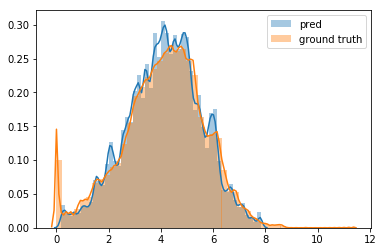

In [59]:
# For meter 0
valid_score, models0, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, target_meter=0, return_info=True)

sns.distplot(y_pred_valid, label='pred')
sns.distplot(y_train, label='ground truth')
plt.legend()
plt.show()

del y_pred_valid, y_train

target_meter 1 (4182440, 35)
cat_features [32, 33, 34]
train 3345952 valid 836488
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.15728	valid_1's l2: 2.49523
[40]	training's l2: 1.74669	valid_1's l2: 1.90063
[60]	training's l2: 1.61824	valid_1's l2: 1.77603
[80]	training's l2: 1.55141	valid_1's l2: 1.73984
[100]	training's l2: 1.49507	valid_1's l2: 1.72703
[120]	training's l2: 1.45636	valid_1's l2: 1.72326
[140]	training's l2: 1.42826	valid_1's l2: 1.72133
[160]	training's l2: 1.38101	valid_1's l2: 1.7123
[180]	training's l2: 1.35333	valid_1's l2: 1.70271
[200]	training's l2: 1.33289	valid_1's l2: 1.69582
[220]	training's l2: 1.30773	valid_1's l2: 1.69697
Early stopping, best iteration is:
[202]	training's l2: 1.32999	valid_1's l2: 1.69549
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.329994749024376}, 'valid_1': {'l2': 1.6954855741314485}})
train 3345952 valid 836488
training LGB:
Training until validation scores don't i

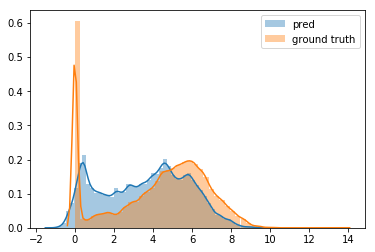

In [60]:
# For meter 1
valid_score, models1, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, target_meter=1, return_info=True)

sns.distplot(y_pred_valid, label='pred')
sns.distplot(y_train, label='ground truth')
plt.legend()
plt.show()

del y_pred_valid, y_train

target_meter 2 (2708713, 35)
cat_features [32, 33, 34]
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.29689	valid_1's l2: 3.00495
[40]	training's l2: 1.87236	valid_1's l2: 2.51437
[60]	training's l2: 1.76626	valid_1's l2: 2.45515
[80]	training's l2: 1.70979	valid_1's l2: 2.43346
[100]	training's l2: 1.66219	valid_1's l2: 2.43209
[120]	training's l2: 1.632	valid_1's l2: 2.42917
Early stopping, best iteration is:
[118]	training's l2: 1.63518	valid_1's l2: 2.42621
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.635182571240415}, 'valid_1': {'l2': 2.4262131144174344}})
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.26956	valid_1's l2: 2.55885
[40]	training's l2: 1.86176	valid_1's l2: 2.36583
[60]	training's l2: 1.75674	valid_1's l2: 2.30083
[80]	training's l2: 1.69729	valid_1's l2: 2.27319
[100]	training's l2: 1.65506	valid

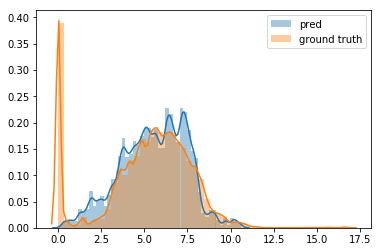

In [61]:
# For meter 2
valid_score, models2, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, target_meter=2, return_info=True)

sns.distplot(y_pred_valid, label='pred')
sns.distplot(y_train, label='ground truth')
plt.legend()
plt.show()

del y_pred_valid, y_train

target_meter 3 (1264037, 35)
cat_features [32, 33, 34]
train 1011229 valid 252808
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.39696	valid_1's l2: 3.29373
[40]	training's l2: 2.07815	valid_1's l2: 2.5796
[60]	training's l2: 1.96741	valid_1's l2: 2.45078
[80]	training's l2: 1.91171	valid_1's l2: 2.4121
[100]	training's l2: 1.8701	valid_1's l2: 2.37769
[120]	training's l2: 1.83578	valid_1's l2: 2.35229
[140]	training's l2: 1.81022	valid_1's l2: 2.34018
[160]	training's l2: 1.78113	valid_1's l2: 2.32956
[180]	training's l2: 1.75736	valid_1's l2: 2.32847
Early stopping, best iteration is:
[178]	training's l2: 1.76068	valid_1's l2: 2.32742
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.7606843542210433}, 'valid_1': {'l2': 2.327417514466249}})
train 1011229 valid 252808
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.30005	valid_1's l2: 2.74566
[40]	training's l2: 1.95346	vali

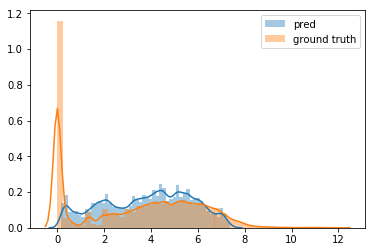

In [62]:
# For meter 3
valid_score, models3, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, target_meter=3, return_info=True)

sns.distplot(y_pred_valid, label='pred')
sns.distplot(y_train, label='ground truth')
plt.legend()
plt.show()

del y_pred_valid, y_train

In [63]:
try:
    del train_df
    del train_df_original
    del weather_train_df
except:
    pass
gc.collect()

7902

## Create test data

In [64]:
print('loading...')
test_df = pd.read_feather(root/'test.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')

print('preprocessing building...')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)

print('preprocessing weather...')
weather_test_df = timestamp_align(weather_test_df)
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

print('reduce mem usage...')
weather_test_df = weather_test_df[['site_id', 'timestamp'] + weather_cols]
reduce_mem_usage(test_df, use_float16=True)
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

loading...


/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 1908.76 MB
Memory usage after optimization is: 874.88 MB
Decreased by 54.2%
Memory usage of dataframe is 19.83 MB
Memory usage after optimization is: 16.13 MB
Decreased by 18.7%


0

In [65]:
del df_2d
del site_ids_offsets
gc.collect()

0

In [66]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left', copy=False)
    target_test_df = pd.merge(target_test_df, building_stats_df, on=['building_id', 'meter'], how='left', copy=False)
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left', copy=False)
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

In [67]:
%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

del X_test
gc.collect()

iterations 25
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 12min 13s, sys: 1min 30s, total: 13min 43s
Wall time: 4min 53s


291

In [68]:
%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()
y_test1 = pred(X_test, models1)

del X_test
gc.collect()

iterations 9
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 8min 57s, sys: 34 s, total: 9min 31s
Wall time: 2min 57s


111

In [69]:
%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()
y_test2 = pred(X_test, models2)

del X_test
gc.collect()

iterations 6
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 3min 47s, sys: 19.4 s, total: 4min 6s
Wall time: 1min 21s


60

In [70]:
%%time
X_test = create_X(test_df, target_meter=3)
gc.collect()
y_test3 = pred(X_test, models3)

del X_test
gc.collect()

iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 2min 10s, sys: 7.52 s, total: 2min 18s
Wall time: 43.6 s


45

Text(0.5, 1.0, 'test prediction for meter type 0')

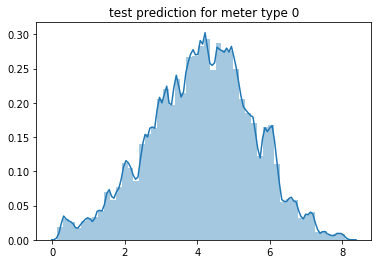

In [71]:
sns.distplot(y_test0)
plt.title('test prediction for meter type 0')

Text(0.5, 1.0, 'test prediction for meter type 1')

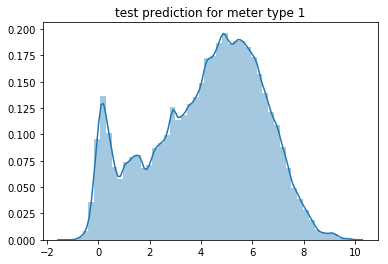

In [72]:
sns.distplot(y_test1)
plt.title('test prediction for meter type 1')

Text(0.5, 1.0, 'test prediction for meter type 2')

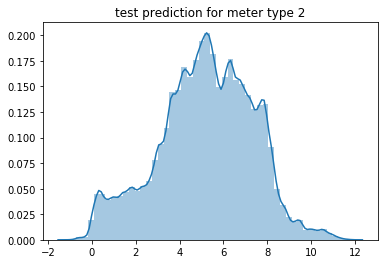

In [73]:
sns.distplot(y_test2)
plt.title('test prediction for meter type 2')

Text(0.5, 1.0, 'test prediction for meter type 3')

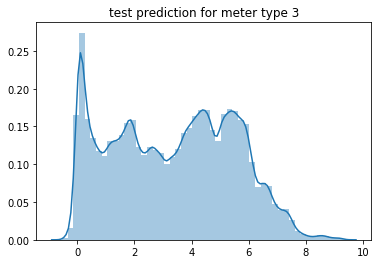

In [74]:
sns.distplot(y_test3)
plt.title('test prediction for meter type 3')

In [75]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
reduce_mem_usage(sample_submission)

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [76]:
print(np.sum(y_test0 < 0))
print(np.sum(y_test1 < 0))
print(np.sum(y_test2 < 0))
print(np.sum(y_test3 < 0))

y_test0 = np.where(y_test0 < 0, 0, y_test0)
y_test1 = np.where(y_test1 < 0, 0, y_test1)
y_test2 = np.where(y_test2 < 0, 0, y_test2)
y_test3 = np.where(y_test3 < 0, 0, y_test3)

0
212795
21567
53384


In [77]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [78]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')

In [79]:
sample_submission.head()

,row_id,meter_reading
0,0,194.948202
1,1,94.455776
2,2,13.220974
3,3,320.353487
4,4,1296.282567


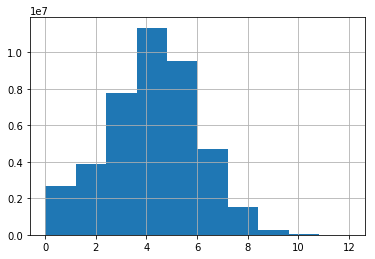

In [80]:
np.log1p(sample_submission['meter_reading']).hist()

In [81]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

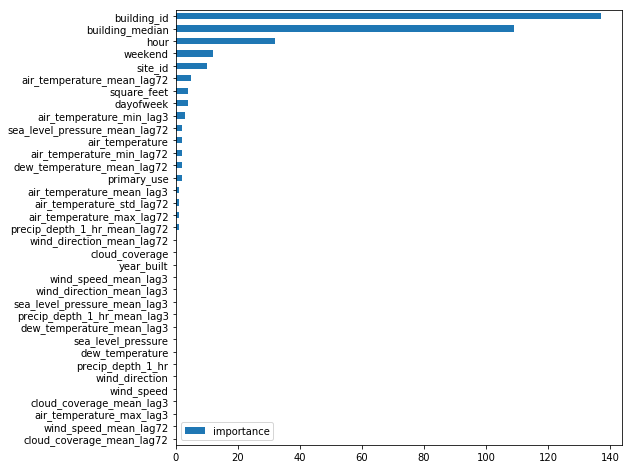

In [82]:
plot_feature_importance(models0[1])

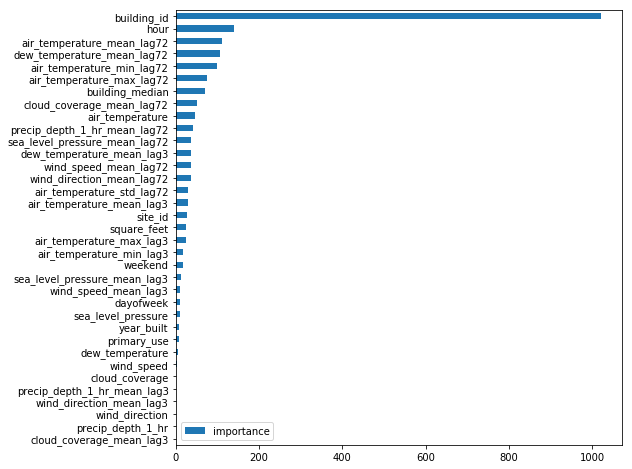

In [83]:
plot_feature_importance(models1[1])

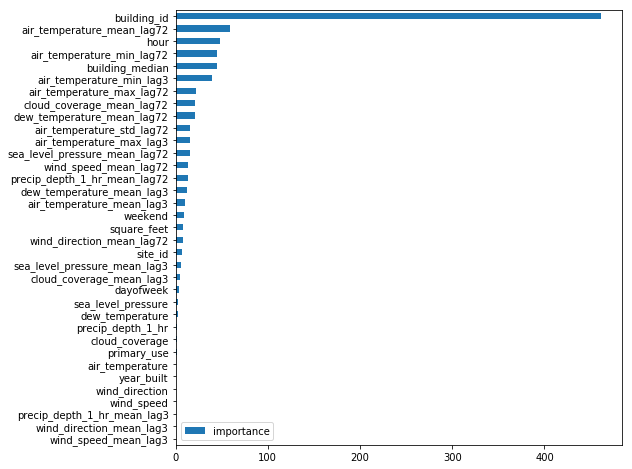

In [84]:
plot_feature_importance(models2[1])

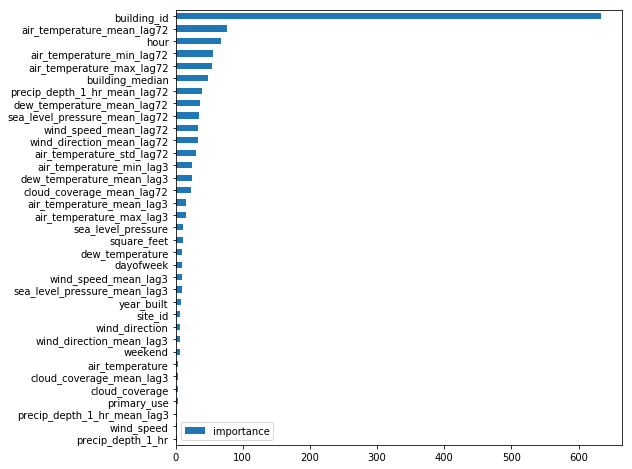

In [85]:
plot_feature_importance(models3[1])

<a id="id10"></a>
# More to go

## Other features...

That's all for this tutorial. However `optuna` further provides other useful functionality.

 - Store trial information in Relational Database (SQLite, PostgreSQL, MySQL) rather than on memory, to save hyperparameter search history.
 - Parallel distributed optimization: you can run several process at the same time to asyncronously search hyperparameters with many CPUs in parallel.

See Official document, github for details!

 - [web site](https://optuna.org/)
 - [github: pfnet/optuna](https://github.com/pfnet/optuna)
 - [document](https://optuna.readthedocs.io/en/latest/)

**Recently LightGBMTuner is introduced (See [this PR#549](https://github.com/pfnet/optuna/pull/549)), maybe it is quite interesting to try!**

If this kernel helps you, please upvote to keep me motivated 😁<br>Thanks!